In [1]:
import torch
import numpy as np
# import gc
# import torch.utils.data.DataLoader as DataLoader
import matplotlib.pyplot as plt

In [2]:
data_dir = '../data/'
train_scan_d = 'training/scan_d/'
test_scan_d = 'test/scan_d/'
train_shot = 'training/reg_shot/'
test_shot = 'test/scan_shot/'
inter = 'inter_challenge.txt'
intra = 'intra_challenge.txt'

In [3]:
assert torch.cuda.is_available()
cuda_device = torch.device("cuda:0")
# print(cuda_device)

cuda:0


In [4]:
def load_shot(fname):
    num = 0
    i = 0
    shot = []
    with open(fname) as f:
        for line in f:
            array = line.split()
            num += len(array)
            if len(array) > 0:
                np_array = np.array(array)
                f_array = np_array.astype(float)
                t_array = torch.from_numpy(f_array)
                shot.append(f_array)
            i = i + 1
    shot_np = np.array(shot)
    shot_np = shot_np[shot_np[:,0].argsort()]
#     print(shot_np)
    shot_ret = shot_np[:, 4:]
    shot_ret = shot_np
    t_shot = torch.from_numpy(shot_ret) #shot_ret
    t_shot = torch.unsqueeze(t_shot, 0).float().to(cuda_device)
#     t_shot = torch.from_numpy(shot_ret).float().to(cuda_device)
    f.close()
    return t_shot

In [5]:
def load_pairs(challenge):
    intraFname = ''.join([data_dir, intra])
    interFname = ''.join([data_dir, inter])
    pairs = []
    assert challenge == 'intra' or challenge == 'inter' or challenge == 'both'
    if challenge == 'intra' or challenge == 'both':
        with open(intraFname) as f:
            for line in f:
                array = line.split('_')
                array[1] = array[1][:-1]
                pairs.append(array)
    if challenge == 'inter' or challenge == 'both':
        with open(interFname) as f:
            for line in f:
                array = line.split('_')
                array[1] = array[1][:-1]
                pairs.append(array)
    return pairs

In [6]:
def compute_l2(des, des2, nump):
    ##
#     des = des.to(cuda_device)
#     des2 = des2.to(cuda_device)
#     des = torch.from_numpy(des).float().to(cuda_device)
#     des2 = torch.from_numpy(des2).float().to(cuda_device)
    
    # maybe add condition that skip this process
    rand_idx = np.random.choice(15000, nump, replace=False)
    ridx_torch = torch.unsqueeze(torch.from_numpy(rand_idx), 0)
    ##
    ridx_torch = ridx_torch.to(cuda_device)
    ridx_torch = torch.sort(ridx_torch[0], dim=-1)[0] # sort returns val and index
    # reduced descriptor
    des_n = torch.index_select(des[0], dim=0, index=ridx_torch)
    des2_n = torch.index_select(des2[0], dim=0, index=ridx_torch)
    with torch.cuda.device(0):
        dist = torch.cdist(des_n, des2_n, p=2)
    del des
    del des2
    del des_n
    del des2_n
    torch.cuda.empty_cache()
    return dist

In [38]:
def find_hitrate(dist, k):
    dist = dist.cpu()
    # returns topk probability in float
    topk = torch.unsqueeze(torch.topk(dist, k, dim=1, largest=False, sorted=True)[1], 0)
    # 1*2500*k

    hit = 0
    size = topk.size(1)
    for i in range(size):
        if i in topk[0, i]:
            hit += 1
    return hit/size

In [65]:
def calculate_dist_map():
    c = 'both'; # inter / intra / both
    t = 'scan'; # reg (registration) / scan
    pairs = load_pairs(c) # only load when t is 'scan'
#     print(pairs)
    xlim = 200
    total_hitrate = [0 for x in range(xlim)]
    for i in range(1, 100):
        fn1 = ''.join([data_dir, test_shot, 'test_scan_d_res_', pairs[i][0], '.txt'])
        fn2 = ''.join([data_dir, test_shot, 'test_scan_d_res_', pairs[i][1], '.txt'])
        shot1 = load_shot(fn1)
        shot2 = load_shot(fn2)
        d_map = compute_l2(shot1, shot2, 2500)

        for j in range(0, xlim):
            total_hitrate[j] += find_hitrate(d_map, j)
        
        if i % 10 == 0:
            cur_hitrate = np.array(total_hitrate)
            cur_hitrate = np.true_divide(cur_hitrate, i)
            print(cur_hitrate)
            plt.plot([x for x in range(xlim)], cur_hitrate)
            plt.show()
        
        del shot1
        del shot2
        torch.cuda.empty_cache()
        
    
    cur_hitrate = np.true_divide(cur_hitrate, xlim)
    plt.plot([x for x in range(xlim)], total_hitrate)
    plt.savefig('shot_dist_map.png')
        
#     return total_hitrate
    return

yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
[0.      0.03    0.0562  0.07824 0.09516 0.10932 0.12    0.12964 0.13936
 0.14944 0.16036 0.1726  0.18608 0.20164 0.2194  0.23836 0.25668 0.27636
 0.29492 0.31488 0.33476 0.35428 0.3748  0.39272 0.41168 0.4308  0.44988
 0.4694  0.48604 0.50416 0.52116 0.53728 0.55304 0.56764 0.58224 0.59628
 0.61    0.62468 0.63804 0.65072 0.66692 0.67616 0.68584 0.69368 0.70252
 0.71164 0.72152 0.73    0.74008 0.7486  0.75552 0.76352 0.77124 0.77848
 0.78768 0.795   0.802   0.80936 0.81608 0.8224  0.82964 0.83636 0.84208
 0.84852 0.85512 0.86156 0.86684 0.87272 0.87728 0.88252 0.88672 0.8906
 0.89488 0.89948 0.90396 0.90772 0.91132 0.91472 0.91876 0.92248 0.92592
 0.92928 0.93268 0.93644 0.93936 0.94204 0.94524 0.94816 0.9502  0.9528
 0.95532 0.9576  0.96064 0.96316 0.96504 0.96708 0.96888 0.97092 0.97272
 0.9744  0.9762  0.97784 0.97916 0.98064 0.98208 0.98332 0.98496 0.98608
 0.98668 0.98768 0.98872 0.98944 0.99028 0.99108 0.99196 0.99256 0.993
 0.99376 0.9943

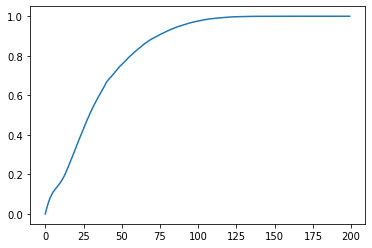

yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
[0.      0.03136 0.0582  0.07982 0.09696 0.1109  0.12158 0.13112 0.14124
 0.1517  0.1631  0.17552 0.18916 0.20476 0.22148 0.24038 0.25894 0.27774
 0.29648 0.31624 0.33636 0.35552 0.37608 0.39444 0.41356 0.43172 0.45074
 0.46964 0.48734 0.50518 0.5223  0.5386  0.55476 0.56932 0.58398 0.59822
 0.61184 0.6261  0.63906 0.6517  0.6637  0.67276 0.68188 0.69074 0.70026
 0.70966 0.71926 0.72798 0.73756 0.74624 0.7544  0.76246 0.77098 0.77866
 0.7872  0.79428 0.802   0.80926 0.81584 0.82284 0.82996 0.83618 0.84182
 0.84806 0.85428 0.86012 0.86576 0.87142 0.87592 0.88104 0.88574 0.8898
 0.89442 0.89904 0.9034  0.90712 0.91102 0.91454 0.91834 0.92246 0.9261
 0.92952 0.93296 0.93632 0.93924 0.9423  0.9457  0.9486  0.95108 0.95364
 0.95618 0.95856 0.96106 0.96346 0.96536 0.96744 0.96922 0.97116 0.97286
 0.97422 0.9761  0.97772 0.97898 0.98032 0.98166 0.98278 0.9843  0.98556
 0.98644 0.98756 0.9887  0.98956 0.99036 0.99126 0.99214 0.9928  0.99328
 0.99382 0.99

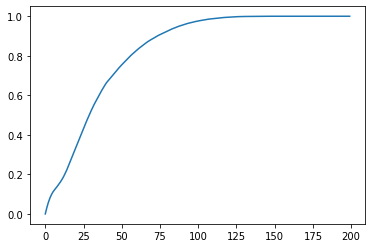

yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
[0.         0.03166667 0.0586     0.0802     0.0976     0.11129333
 0.12202667 0.1318     0.14186667 0.15234667 0.16378667 0.176
 0.18994667 0.20592    0.22298667 0.24144    0.26018667 0.27921333
 0.29754667 0.31676    0.33658667 0.35629333 0.37625333 0.39553333
 0.41533333 0.43448    0.45304    0.47178667 0.48966667 0.50770667
 0.52484    0.54133333 0.55713333 0.572      0.58657333 0.60081333
 0.61425333 0.628      0.64082667 0.65308    0.66409333 0.67348
 0.68278667 0.69198667 0.7014     0.71128    0.72092    0.72978667
 0.73881333 0.74736    0.75628    0.76465333 0.77278667 0.78033333
 0.7884     0.79534667 0.80316    0.81036    0.81693333 0.82392
 0.83096    0.83705333 0.84268    0.84868    0.85446667 0.86024
 0.866      0.87133333 0.87584    0.88096    0.88581333 0.89018667
 0.89472    0.89910667 0.90324    0.90713333 0.91104    0.91464
 0.91822667 0.92217333 0.92597333 0.92946667 0.93270667 0.93618667
 0.93926667 0.94229333 0.94550667 0.948

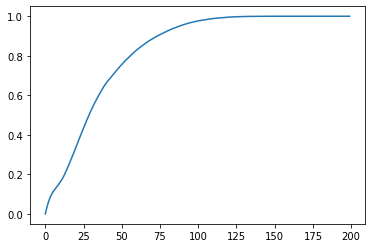

yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
[0.      0.03192 0.05863 0.08019 0.0974  0.11107 0.12195 0.1316  0.14176
 0.1524  0.16405 0.17625 0.19015 0.20624 0.22342 0.2417  0.26055 0.27964
 0.29817 0.31745 0.33689 0.35602 0.37562 0.39441 0.41399 0.43299 0.4516
 0.47019 0.48778 0.50571 0.52255 0.53876 0.55454 0.56972 0.58458 0.59895
 0.61221 0.62584 0.63875 0.65148 0.66376 0.67314 0.68275 0.69218 0.70152
 0.71121 0.72058 0.72945 0.73823 0.74671 0.75565 0.76389 0.77202 0.77976
 0.78784 0.79493 0.8027  0.80973 0.81639 0.82308 0.82985 0.8361  0.84206
 0.8481  0.8539  0.85956 0.86539 0.87056 0.87516 0.8803  0.88506 0.88944
 0.8939  0.89833 0.9023  0.90623 0.90995 0.91349 0.91707 0.92088 0.92458
 0.92814 0.93149 0.93493 0.938   0.941   0.94421 0.94713 0.94967 0.95245
 0.95515 0.95756 0.96026 0.96269 0.965   0.96717 0.969   0.97091 0.97275
 0.97422 0.97598 0.97754 0.97879 0.98016 0.98151 0.98265 0.984   0.98528
 0.98626 0.98731 0.98829 0.98902 0.98975 0.99054 0.99134 0.99203 0.9926
 0.9933  0.99

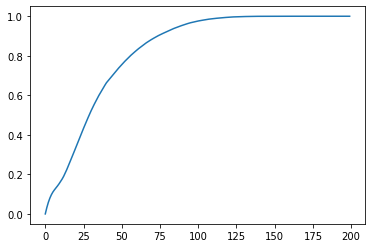

yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
[0.       0.03204  0.058672 0.080352 0.097512 0.110968 0.121864 0.131568
 0.14164  0.152264 0.163968 0.176272 0.190304 0.206264 0.223536 0.241824
 0.260872 0.280056 0.298632 0.317824 0.337    0.356296 0.375888 0.394888
 0.414608 0.433616 0.452112 0.470728 0.488096 0.506168 0.523112 0.539232
 0.55504  0.57044  0.5852   0.599816 0.613024 0.6266   0.63968  0.652392
 0.66372  0.673144 0.682736 0.692216 0.701696 0.711152 0.720408 0.729304
 0.738304 0.74672  0.755552 0.763776 0.771864 0.779664 0.787688 0.794848
 0.802792 0.80992  0.816696 0.823304 0.829832 0.836112 0.842056 0.848112
 0.853912 0.859472 0.865312 0.87052  0.875208 0.880192 0.884952 0.889296
 0.893704 0.898136 0.9022   0.906216 0.91004  0.913568 0.91732  0.921176
 0.924896 0.928432 0.931792 0.935192 0.938296 0.941376 0.944504 0.94752
 0.950136 0.952856 0.955504 0.957944 0.96056  0.962848 0.96504  0.967168
 0.96896  0.970864 0.972672 0.974064 0.975816 0.9774   0.978792 0.980144
 0.981456 0.

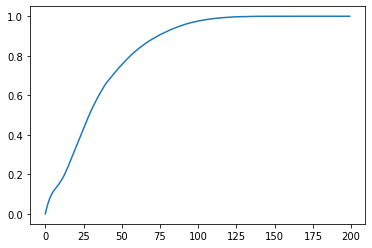

yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
[0.         0.032      0.05869333 0.08021333 0.09722    0.1109
 0.12170667 0.1313     0.14139333 0.15214    0.16364    0.17610667
 0.19016667 0.20602    0.22364    0.24210667 0.26108    0.28054
 0.29921333 0.31854    0.33748667 0.35679333 0.37622    0.39543333
 0.41528    0.43427333 0.45256    0.4708     0.48816    0.50619333
 0.52289333 0.53908    0.5549     0.57025333 0.58512    0.59975333
 0.61304667 0.62647333 0.63944    0.65212667 0.66384667 0.67316667
 0.68280667 0.69239333 0.70165333 0.71104667 0.72035333 0.72933333
 0.73838    0.74676667 0.75554667 0.76368    0.7718     0.77971333
 0.78758    0.79465333 0.80244    0.80952667 0.81630667 0.82284
 0.82934    0.8356     0.84158    0.84771333 0.8536     0.85914667
 0.8649     0.87004    0.87460667 0.87965333 0.88438    0.88882667
 0.8933     0.89771333 0.90179333 0.90580667 0.90959333 0.9131
 0.91689333 0.92084667 0.92451333 0.92802    0.93142    0.9348
 0.93797333 0.94113333 0.94434667 0.9472

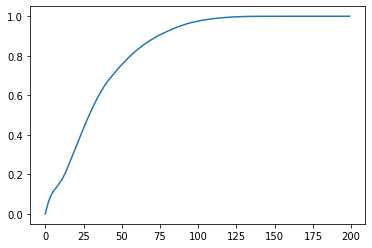

yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
[0.         0.03184    0.05874286 0.08018857 0.09712571 0.111
 0.122      0.13153143 0.14156571 0.15226286 0.16377143 0.17634857
 0.19072571 0.20643429 0.22390857 0.24251429 0.26124571 0.28039429
 0.29916    0.31822286 0.33710286 0.35626857 0.37557714 0.39473714
 0.41482857 0.43394857 0.45226857 0.47061143 0.48808    0.50599429
 0.52278286 0.53892    0.55454286 0.56983429 0.58468571 0.59936571
 0.61284    0.62630286 0.63925714 0.65198857 0.66412571 0.67353143
 0.68312    0.69269143 0.70174286 0.71107429 0.72038286 0.72944571
 0.73846286 0.74680571 0.75534857 0.76349143 0.77153714 0.77944
 0.78718857 0.79413143 0.80191429 0.80894857 0.81564    0.82214857
 0.82864    0.83495429 0.84091429 0.84708571 0.85293714 0.85856
 0.86433714 0.86953714 0.87416571 0.87917143 0.88384    0.88834286
 0.89291429 0.89737714 0.90148    0.90551429 0.90942857 0.91306286
 0.91694857 0.92088    0.92450857 0.92795429 0.93125714 0.93457143
 0.93777143 0.94097714 0.94420571

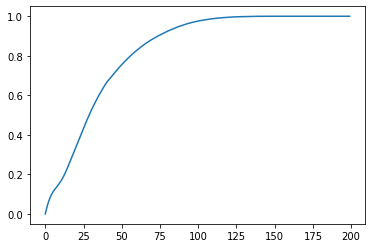

yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
[0.       0.03207  0.05891  0.080375 0.09737  0.11124  0.12228  0.13194
 0.14195  0.152585 0.164    0.176625 0.19099  0.206625 0.224045 0.242545
 0.261305 0.280475 0.29932  0.31842  0.33741  0.35668  0.37579  0.39477
 0.414645 0.43363  0.45205  0.470395 0.487775 0.505615 0.522405 0.538495
 0.55408  0.569365 0.584315 0.598925 0.6125   0.625975 0.63893  0.65167
 0.664445 0.67382  0.683455 0.69293  0.70199  0.711305 0.720545 0.72962
 0.73849  0.74673  0.7552   0.76342  0.77157  0.77943  0.78711  0.79415
 0.801855 0.8089   0.815565 0.822045 0.828565 0.83492  0.840875 0.84704
 0.852935 0.85841  0.86411  0.86925  0.8739   0.87886  0.88354  0.8881
 0.892755 0.89719  0.901315 0.905375 0.90939  0.91307  0.91692  0.92079
 0.924405 0.927915 0.93123  0.93454  0.93775  0.94095  0.94412  0.94702
 0.94969  0.9525   0.955185 0.95767  0.96029  0.962595 0.964785 0.96695
 0.968785 0.970635 0.97247  0.974035 0.97576  0.977355 0.978725 0.98007
 0.98135  0.982555 0.98

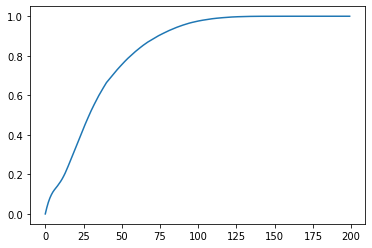

yay
yay
yay
yay
yay
yay
yay
yay
yay
yay
[0.         0.03210222 0.05902222 0.08045778 0.09751111 0.11128444
 0.12233778 0.13208444 0.14195111 0.15258667 0.16405333 0.17675556
 0.19112889 0.20657333 0.22390667 0.24231111 0.26112444 0.28040444
 0.29927111 0.31856    0.33746667 0.35681333 0.37594667 0.39495556
 0.41451556 0.43345778 0.45192889 0.47025333 0.48757778 0.50533333
 0.52218222 0.53847556 0.55411111 0.56953333 0.58450222 0.59899556
 0.6128     0.62637778 0.63935111 0.65196444 0.66489778 0.67432889
 0.68396889 0.69336444 0.7024     0.71168    0.72091556 0.72994222
 0.73862222 0.74675556 0.75528    0.76352889 0.77168889 0.77951111
 0.78722222 0.79432    0.80200444 0.809      0.81569333 0.82221333
 0.82861778 0.83499111 0.84090222 0.84701778 0.85278667 0.85824889
 0.86394667 0.86896889 0.87368889 0.87861333 0.88339111 0.88793333
 0.89261333 0.89696889 0.90109333 0.90513778 0.90911111 0.91275556
 0.91656444 0.92042667 0.92410222 0.92764    0.93101333 0.93437333
 0.93758222 0.94079556

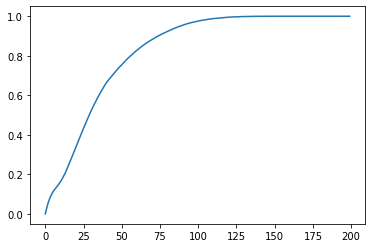

yay
yay
yay
yay
yay
yay
yay
yay
yay


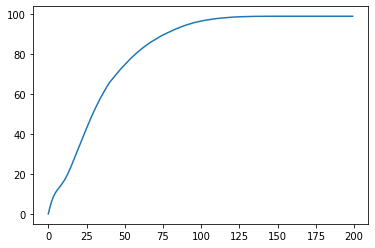

In [67]:
calculate_dist_map()